# 作业1-构建两层两层神经网络分类器
## <p align="right">22210980067 饶双智</p>

### 1、简介

这是一个使用NumPy构建的简单两层神经网络分类器，用于分类MNIST数据集。

这里分为三部分：训练、参数查找和测试。
1. 训练
   - 首先定义了sigmoid函数和softmax函数用做激活函数，并且计算了激活函数的梯度。然后利用L2正则化定义了loss函数
   - 利用反向传播算法计算梯度，进行了具体推导和代码实现
   - 学习率下降策略使用指数衰减：每经过epochs个epoch后学习率乘以一个衰减率decay_rate，通过实际训练最后确定epochs=100，decay_rate=0.9可以得到较好的效果
   - 具体实现模型训练，其中采用SGD优化器，随机选取batch_size个样本计算梯度，更新参数。
   - 保存模型参数到文件“params.npz”
2. 超参数查找：
   - 通过网格搜索，大致搜寻合适的学习率、隐藏层大小、正则化强度和batch_size
   - 学习率设置[0,001,0.01,0.1]
   - 隐藏层设置[50,100,200]
   - 正则化强度设置[0.0001,0.001,0.01]
   - batch_sizes设置[64,128,256]
   - 由于SGD优化存在一定随机性，所以每次训练过程采用五折交叉验证，四份当训练集，一份当测试集，取五次准确率的平均值作为对应参数所相应的准确率
   - 最后基于寻找到的合适超参数，根据发现规律进行微调，得到一个最佳的参数结果，并进行训练，得到模型并存储，绘制loss和accuracy曲线，并可视化每层网络参数
3. 测试：
   导入模型，用经过参数查找后的模型进行测试，输出分类精度


### 2、训练：

#### 2.1 利用反向传播算法推导梯度
我们定义的loss函数为：
$$ L=-\dfrac{1}{n} \sum_{i=1}^{n} \sum_{j=0}^{9} y_{ij} \log p_{ij} + \frac{1}{2} \lambda (\Vert W_1 \Vert _F^2+\Vert W_2 \Vert _F^2 )$$

其中$p_{ij}$即为第$i$个输入为数字$j$的概率，设$p_i=(p_{i0},p_{i1},\dots,p_{i9})$,实际值为$y_i=(0,\dots,1,\dots,0)$,那么第$i$个样本对应的loss为$$L_i=y^T \log p$$,那么 $$ L=-\dfrac{1}{n} \sum_{i=1}^{n} L_i + \frac{1}{2} \lambda (\Vert W_1 \Vert _F^2+\Vert W_2 \Vert _F^2 ) = L_s + L_r $$，其中$L_s$表示样本交叉熵，$L_r$表示正则项

我们再看两层神经网络的构造 ：
\begin{align}
&z_1=xW_1+b_1\\
&a_1=\sigma(z_1)\\
&z_2=a_1W_2+b_2\\
&a_2=\text{softmax}(z_2)
\end{align}
其中$a_2=(p_0,p_1,\dots,p_9)$，$p_j$表示该数字为$j$的概率，那么loss函数中的$p_{ij}$即对应$a_{2(i,j)}$,即第$i$个样本对应的输出$a_{2(i)}$的第$j+1$项,$i=1,\dots,n \  ,j=0,1,\dots,9 $

那么我们利用反向传播对参数$W_2,b_2,W_1,b_1$进行求导:

首先有$L_i=y^T \log p =  \sum_{j=0}^{9} y_{ij} \log p_{ij} $表示第$i$个样本对应的损失。那么我们计算
\begin{align*}
\dfrac{ \partial L_i }{ \partial z_{2(i,j)} }&=\dfrac{ \partial }{ \partial z_{2(i,j)} } \sum_{k=0}^{9} y_{ik} \log p_{ik}\\
&=\sum_{k=0}^{9} \dfrac{ \partial }{ \partial z_{2(i,j)}} y_{ik} \log p_{ik} \\
&=\sum_{k=0}^{9} \dfrac{ \partial }{ \partial z_{2(i,j)}} y_{ik} \log a_{2(i,k)}\\
&=\sum_{k=0}^{9} \dfrac{ \partial }{ \partial z_{2(i,j)}} y_{ik} \log \frac{e^{z_{2(i,k)}}}{\sum_{t=0}^9 e^{z_{2(i,t)}} }\\
&=\sum_{k=0}^{9} \dfrac{ \partial }{ \partial z_{2(i,j)}} y_{ik} (\log e^{z_{2(i,k)}} - \log(\sum_{t=0}^9 e^{z_{2(i,t)}} ) )\\
&=\sum_{k=0}^{9} \dfrac{ \partial }{ \partial z_{2(i,j)}} y_{ik} (z_{2(i,k)} - \log(\sum_{t=0}^9 e^{z_{2(i,t)}} ) )\\
&= \dfrac{ \partial }{ \partial z_{2(i,j)}}(y_{ij} (z_{2(i,j)} - \log(\sum_{t=0}^9 e^{z_{2(i,t)}} ) )) + \sum_{k \neq j } \dfrac{ \partial }{ \partial z_{2(i,j)}} y_{ik} (z_{2(i,k)} - \log(\sum_{t=0}^9 e^{z_{2(i,t)}} ) )\\
&=y_{ij}(1-\frac{e^{z_{2(i,j)}}}{\sum_{t=0}^9 e^{z_{2(i,t)}} }) + \sum_{k \neq j } (- y_{ik} \frac{e^{z_{2(i,j)}}}{\sum_{t=0}^9 e^{z_{2(i,t)}} }) \\
&=y_{ij}-\sum_{k=0}^{9}y_{ik} \frac{e^{z_{2(i,j)}}}{\sum_{t=0}^9 e^{z_{2(i,t)}} }\\
&=y_{ij}-(\sum_{k=0}^{9}y_{ik}) p_{ij}\\
&=y_{ij}-p_{ij}
\end{align*}
那么向量形式我们有
\begin{align*}
\dfrac{ \partial L_i }{ \partial z_{2(i)} }&= y_{i}-p_{i}
\end{align*}
从而有
\begin{align*}
\dfrac{ \partial L_s }{ \partial z_{2} }&= -\frac{1}{n} \sum_{i=1}^{n}(y_{i}-p_{i})
\end{align*}

考虑矩阵求导的链式法则，我们有向量$x,y$到标量$z$,其中$x$为$1*m$向量，$y$为$1*n$向量，那么导数为
\begin{align*}
\dfrac{ \partial z }{ \partial x }&= \dfrac{ \partial z }{ \partial y } \cdot (\dfrac{ \partial y }{ \partial x })^T\\
\end{align*}
其中$\dfrac{ \partial y }{ \partial x }$为$m*n$维矩阵，$\dfrac{ \partial z }{ \partial y }$为$1*n$维向量

有标量对多矩阵链式求导，假设有$z=f(y),y=xA+b$,其中$z$为标量，$x$为$1*m$向量，$y,b$为$1*n$向量,$A$为$m*n$维矩阵,那么有
\begin{align*}
\dfrac{ \partial z }{ \partial x }&= \dfrac{ \partial z }{ \partial y } \cdot A^T
\end{align*}
以及
\begin{align*}
\dfrac{ \partial z }{ \partial A }&=  x^T \cdot \dfrac{ \partial z }{ \partial y } 
\end{align*}

那么根据链式法则有
\begin{align*}
\dfrac{ \partial L }{ \partial W_{2} }&=\dfrac{ \partial L_s }{ \partial W_{2} }+\dfrac{ \partial L_r }{ \partial W_{2} }\\
&=a_1^T \cdot \dfrac{ \partial L_s }{ \partial z_{2} }+\dfrac{ \partial \frac{1}{2} \lambda (\Vert W_1 \Vert _F ^2 +\Vert W_2 \Vert _F^2 ) }{ \partial W_{2} }\\
&=a_1^T \cdot \dfrac{ \partial L_s }{ \partial z_{2} } + \lambda W_2 
\end{align*}

\begin{align*}
\dfrac{ \partial L }{ \partial b_{2} }&=\dfrac{ \partial L_s }{ \partial b_{2} }+\dfrac{ \partial L_r }{ \partial b_{2} }\\
&=\dfrac{ \partial L_s }{ \partial z_{2} } \cdot (\dfrac{ \partial z_2 }{ \partial b_{2} })^T +\dfrac{ \partial \frac{1}{2} \lambda (\Vert W_1 \Vert _F^2+\Vert W_2 \Vert _F^2 ) }{ \partial b_{2} }\\
&=\dfrac{ \partial L_s }{ \partial z_{2} }
\end{align*}
那么对于第一层有
\begin{align*}
\dfrac{ \partial L_s }{ \partial z_{1} }&=\dfrac{ \partial L_s }{ \partial z_{2} } \cdot (\dfrac{ \partial z_2 }{ \partial a_{1} }) \odot (\dfrac{ \partial a_1 }{ \partial z_{1} })\\
&=\dfrac{ \partial L_s }{ \partial z_{2} } \cdot (\dfrac{ \partial z_2 }{ \partial a_{1} }) \odot z_1 \odot (1-z_1)\\
\end{align*}
从而有
\begin{align*}
\dfrac{ \partial L }{ \partial W_{1} }&=\dfrac{ \partial L_s }{ \partial W_{1} }+\dfrac{ \partial L_r }{ \partial W_{1} }\\
&=a_1^T \cdot \dfrac{ \partial L_s }{ \partial z_{1} }+\dfrac{ \partial \frac{1}{2} \lambda (\Vert W_1 \Vert _F ^2 +\Vert W_2 \Vert _F^2 ) }{ \partial W_{1} }\\
&=a_1^T \cdot \dfrac{ \partial L_s }{ \partial z_{1} } + \lambda W_1 
\end{align*}

\begin{align*}
\dfrac{ \partial L }{ \partial b_{1} }&=\dfrac{ \partial L_s }{ \partial b_{1} }+\dfrac{ \partial L_r }{ \partial b_{1} }\\
&=\dfrac{ \partial L_s }{ \partial z_{1} } \cdot (\dfrac{ \partial z_1 }{ \partial b_{1} })^T +\dfrac{ \partial \frac{1}{2} \lambda (\Vert W_1 \Vert _F^2+\Vert W_2 \Vert _F^2 ) }{ \partial b_{1} }\\
&=\dfrac{ \partial L_s }{ \partial z_{1} }
\end{align*}

#### 2.2、模型训练——代码实现

首先，我们需要导入相关库，下载和加载MNIST数据集。

In [1]:
#导入相关库，下载数据集
import numpy as np
import gzip
import pickle
from urllib.request import urlretrieve

urlretrieve("https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz", "mnist.pkl.gz")

with gzip.open("mnist.pkl.gz", "rb") as f:
    ((x_train, y_train), (x_val, y_val), (x_test, y_test)) = pickle.load(f, encoding="latin1")

接下来，我们定义激活函数、损失函数以及它们的梯度。

In [2]:
# 定义激活函数
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x)) #sigmoid函数

# 定义激活函数导数
def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x)) #sigmoid函数导数

# softmax函数，用来最后一层输出多分类的概率分布
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

#softmax函数导数
def softmax_prime(x):
    return softmax(x)*(1-softmax(x))    #softmax函数导数

# loss函数，使用交叉熵损失函数来计算损失，并进行L2正则化
def cross_entropy_loss(y_true, y_pred, W1, W2, reg_lambda):
    m = y_true.shape[0]
    #进行平滑操作，防止出现log0的情况
    y_pred = np.clip(y_pred, 1e-8, 1 - 1e-8)

    loss = -np.sum(y_true * np.log(y_pred)) / m
    loss += 0.5 * reg_lambda * (np.sum(W1 * W1) + np.sum(W2 * W2))
    return loss

然后，我们实现训练过程中的前向传播、反向传播以及梯度计算。

In [3]:
#前向传播
def forward_propagation(x, W1, b1, W2, b2):
    z1 = np.dot(x, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

#反向传播
def back_propagation(x, y, z1, a1, z2, a2, W1, W2, reg_lambda):
    m = x.shape[0]

    delta3 = a2 - y
    dW2 = np.dot(a1.T, delta3) + reg_lambda * W2
    db2 = np.sum(delta3, axis=0, keepdims=True)

    delta2 = np.dot(delta3, W2.T) * sigmoid_prime(z1)
    dW1 = np.dot(x.T, delta2) + reg_lambda * W1
    db1 = np.sum(delta2, axis=0, keepdims=True)


    return dW1, db1, dW2, db2

In [56]:
#定义学习率衰减策略
def learning_rate_decay(learning_rate, epoch):
    #每100个epoch，学习率衰减为原来的0.9倍
    if epoch % 100 == 0 and epoch != 0:
        learning_rate *= 0.95
    return learning_rate

    

#将标签数据转化为 one-hot 编码的函数
def one_hot(y, n_classes):
    one_hot_y = np.zeros((y.shape[0], n_classes))
    one_hot_y[np.arange(y.shape[0]), y] = 1
    return one_hot_y

    
#训练神经网络
def train(x_train, y_train, x_val, y_val, hidden_size, learning_rate, reg_lambda, epochs,num_epochs,batch_size):
    #获取输入输出维度
    input_size = x_train.shape[1]
    output_size = np.unique(y_train).shape[0]
    # 对标签进行 one-hot 编码
    y_one_hot = one_hot(y_train, output_size)
    y_val_one_hot = one_hot(y_val, output_size)

    # 初始化参数
    W1 = 0.01 * np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    W2 = 0.01 * np.random.randn(hidden_size, output_size)
    b2 = np.zeros((1, output_size))

    #创建两个列表用于存储训练集和验证集的损失
    train_loss_list = []
    val_loss_list = []
    #创建两个列表用于存储训练集和验证集的准确率
    train_acc_list = []
    val_acc_list = []


    for epoch in range(num_epochs):
        #SGD优化器
        #随机抽取batch_size个样本
        batch_mask = np.random.choice(x_train.shape[0], batch_size)
        x_batch = x_train[batch_mask]
        y_batch = y_one_hot[batch_mask]
        #前向传播
        z1, a1, z2, a2 = forward_propagation(x_batch, W1, b1, W2, b2)
        #反向传播
        dW1, db1, dW2, db2 = back_propagation(x_batch, y_batch, z1, a1, z2, a2, W1, W2, reg_lambda)
    
        #更新参数
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        

        #学习率衰减
        learning_rate = learning_rate_decay(learning_rate, epoch)
        #每隔epochs打印一次损失
        if epoch % (int(epochs/2)) == 0:
            #计算训练集和验证集的损失
            _, _, _, a_train = forward_propagation(x_train, W1, b1, W2, b2)
            train_loss = cross_entropy_loss(y_one_hot, a_train, W1, W2, reg_lambda)
            train_accuracy = np.mean(np.argmax(a_train, axis=1) == y_train)
            #train_accuracy = np.mean(np.array_equal(np.argmax(a_train, axis=1), y_one_hot))
            
            _, _, _, a_val = forward_propagation(x_val, W1, b1, W2, b2)
            val_loss = cross_entropy_loss(y_val_one_hot, a_val, W1, W2, reg_lambda)
            val_accuracy = np.mean(np.argmax(a_val, axis=1) == y_val)
            #val_accuracy = np.mean(np.array_equal(np.argmax(a_val, axis=1), y_val))
            if epoch % epochs == 0:
                print("learning_rate：{}".format(learning_rate))
                print(f'Epoch {epoch}/{num_epochs}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}')
            #每隔epochs/2将损失和准确率存储到列表中
            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            train_acc_list.append(train_accuracy)
            val_acc_list.append(val_accuracy)

    return W1, b1, W2, b2, train_loss_list, val_loss_list, train_acc_list, val_acc_list

#导入绘图所用的包
import matplotlib.pyplot as plt



#绘制损失曲线和准确率曲线
def plot_loss_acc(train_loss_list, val_loss_list, train_acc_list, val_acc_list, params):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='train_loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='train_acc')
    plt.plot(val_acc_list, label='val_acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #设置两个图公共的标题,标题分两行显示
    plt.suptitle('Loss and Accuracy', fontsize=16)
    #设置说明标签，用来说明对应参数大小
    plt.figtext(0.5, -0.02, "{}".format(params),ha='center', fontsize=12)
    
    return plt

#测试神经网络
def test_network(X, y, W1, b1, W2, b2):
    _, _, _, a2 = forward_propagation(X, W1, b1, W2, b2)
    accuracy = np.mean(np.argmax(a2, axis=1) == y)
    return accuracy

接下来训练一个神经网络作为示例

learning_rate：0.01
Epoch 0/200: train_loss=2.3550, train_accuracy=0.1020, val_loss=2.3547, val_accuracy=0.1030
learning_rate：0.01
Epoch 10/200: train_loss=2.3540, train_accuracy=0.0986, val_loss=2.3587, val_accuracy=0.0991
learning_rate：0.01
Epoch 20/200: train_loss=2.3131, train_accuracy=0.0998, val_loss=2.3109, val_accuracy=0.0961
learning_rate：0.01
Epoch 30/200: train_loss=2.2249, train_accuracy=0.2275, val_loss=2.2230, val_accuracy=0.2267
learning_rate：0.01
Epoch 40/200: train_loss=2.0593, train_accuracy=0.4661, val_loss=2.0556, val_accuracy=0.4736
learning_rate：0.01
Epoch 50/200: train_loss=1.7547, train_accuracy=0.4823, val_loss=1.7481, val_accuracy=0.4879
learning_rate：0.01
Epoch 60/200: train_loss=1.4862, train_accuracy=0.5253, val_loss=1.4738, val_accuracy=0.5333
learning_rate：0.01
Epoch 70/200: train_loss=1.2700, train_accuracy=0.6359, val_loss=1.2470, val_accuracy=0.6582
learning_rate：0.01
Epoch 80/200: train_loss=1.1157, train_accuracy=0.6531, val_loss=1.0873, val_accuracy=

<module 'matplotlib.pyplot' from 'c:\\Users\\001\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

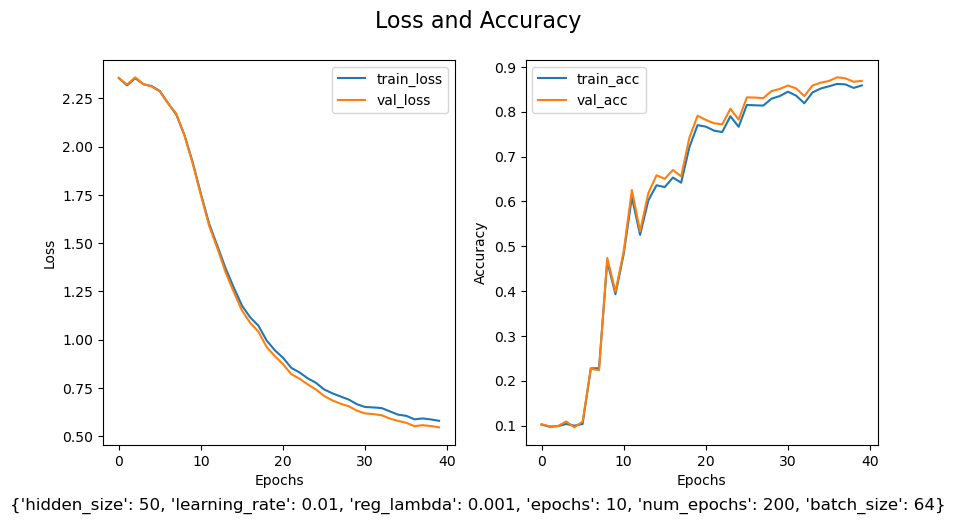

In [58]:
#训练神经网络
params = {
            'hidden_size': 50,
            'learning_rate': 0.01,
            'reg_lambda': 0.001,
            'epochs': 10,
            'num_epochs': 200,
            'batch_size': 64
                }
W1, b1, W2, b2, train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(x_train, y_train, x_val, y_val, 
hidden_size=params['hidden_size'], learning_rate=params['learning_rate'],reg_lambda=params['reg_lambda'], 
epochs=params['epochs'],num_epochs=params['num_epochs'],batch_size=params['batch_size'])

#存储训练结果参数
np.savez('params.npz', W1=W1, b1=b1, W2=W2, b2=b2)

# 导入结果参数
with np.load("params.npz") as f:
    W1, b1, W2, b2 = f['W1'], f['b1'], f['W2'], f['b2']

#测试神经网络
test_accuracy = test_network(x_test, y_test, W1, b1, W2, b2)
print(f'Test accuracy: {test_accuracy:.4f}')

#绘制损失曲线和准确率曲线
plot_loss_acc(train_loss_list, val_loss_list, train_acc_list, val_acc_list, params)


### 3、超参数查找：

在这里，我们使用网格搜索方法粗略寻找最优超参数，并利用交叉验证计算每个超参数选择下的accuracy。

In [30]:
#训练神经网络,用以进行参数的选择，精简版，略去输出部分
def train_select(x_train, y_train, hidden_size, learning_rate, reg_lambda,num_epochs,batch_size):
    #获取输入输出维度
    input_size = x_train.shape[1]
    output_size = np.unique(y_train).shape[0]
    # 对标签进行 one-hot 编码
    y_one_hot = one_hot(y_train, output_size)
   

    # 初始化参数
    W1 = 0.01 * np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    W2 = 0.01 * np.random.randn(hidden_size, output_size)
    b2 = np.zeros((1, output_size))




    for epoch in range(num_epochs):
        #SGD优化器
        #随机抽取batch_size个样本
        batch_mask = np.random.choice(x_train.shape[0], batch_size)
        x_batch = x_train[batch_mask]
        y_batch = y_one_hot[batch_mask]
        #前向传播
        z1, a1, z2, a2 = forward_propagation(x_batch, W1, b1, W2, b2)
        #反向传播
        dW1, db1, dW2, db2 = back_propagation(x_batch, y_batch, z1, a1, z2, a2, W1, W2, reg_lambda)
    
        #更新参数
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        

        #学习率衰减
        learning_rate = learning_rate_decay(learning_rate, epoch)
    return W1, b1, W2, b2

In [ ]:
#设置参数列表
hidden_sizes = [50, 100,200]
learning_rates = [0.001,0.01, 0.1]
reg_lambdas = [0.0001,0.001, 0.01]
batch_sizes = [64,128,256]

best_val_accuracy = -1
best_params = None

#使用五折交叉验证来选择最佳参数
#随机打乱数据集
shuffle_index = np.random.permutation(x_train.shape[0])
x_select = x_train[shuffle_index]
y_select = y_train[shuffle_index]


#将训练集分成5份
x_train_folds = np.array_split(x_select, 5)
y_train_folds = np.array_split(y_select, 5)

#遍历参数列表
for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for reg_lambda in reg_lambdas:
            for batch_size in batch_sizes:
                #初始化验证集的损失和准确率
                val_loss = 0
                val_accuracy = 0
                #遍历每一份作为验证集，其余作为训练集
                for i in range(5):
                    x_val_select = x_train_folds[i]
                    y_val_select = y_train_folds[i]
                    x_train_select  = np.concatenate(x_train_folds[:i] + x_train_folds[i+1:])
                    y_train_select  = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])



                    #训练神经网络
                    W1, b1, W2, b2 = train_select(x_train_select, y_train_select, hidden_size, learning_rate, reg_lambda, num_epochs=400, batch_size=batch_size)
                    #计算验证集的准确率
                    _, _, _, a_val_select = forward_propagation(x_val_select, W1, b1, W2, b2)
                    val_accuracy += np.mean(np.argmax(a_val_select, axis=1) == y_val_select)
                val_accuracy /= 5

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_params = {
                    'hidden_size': hidden_size,
                    'learning_rate': learning_rate,
                    'reg_lambda': reg_lambda,
                    'batch_size': batch_size
                }
                print(f'Best parameters: {best_params},best_val_accuracy={best_val_accuracy:.4f}')
                print(f'hidden_size={hidden_size}, learning_rate={learning_rate}, reg_lambda={reg_lambda},batch_size={batch_size}: val_accuracy={val_accuracy:.4f}')


Best parameters: {'hidden_size': 50, 'learning_rate': 0.01, 'reg_lambda': 0.001, 'batch_size': 256},best_val_accuracy=0.9332

可以看到网格搜索得到的最优超参数为：hidden_size=50,learning_rate=0.01,reg_lambda=0.001,batch_size=256
- 隐藏层大小为50时，即取得了很不错的分类精度，甚至在迭代次数为200时比隐藏层为100、200要更好。所以我们即使用隐藏层大小为50的模型，更简单并且有更好的效果。
- 学习率相较于0.1和0.001，0.01的效果更好，说明学习率不能偏大或者偏小，可以在0.01附近继续进行调试，寻找更优的学习率。
- 正则化大小同样不宜偏大或偏小，我们可以在0.001附近继续进行调试，寻找更优的正则化大小。
- batch_size为256时，效果最好，说明batch_size更大的时候效果更好，可以得到更平滑的梯度，从而加速收敛速度，但同样过大的batch_size也会导致训练速度变慢，同时有可能使得模型陷入局部最优解。但是该模型数据量较小，所以可以尝试更大的batch_size。

learning_rate：0.006
Epoch 0/2000: train_loss=2.5101, train_accuracy=0.1136, val_loss=2.5185, val_accuracy=0.1064
learning_rate：0.0057
Epoch 100/2000: train_loss=0.4166, train_accuracy=0.8940, val_loss=0.3924, val_accuracy=0.8994
learning_rate：0.005415
Epoch 200/2000: train_loss=0.3412, train_accuracy=0.9285, val_loss=0.3268, val_accuracy=0.9332
learning_rate：0.0051442499999999995
Epoch 300/2000: train_loss=0.3254, train_accuracy=0.9395, val_loss=0.3186, val_accuracy=0.9436
learning_rate：0.004887037499999999
Epoch 400/2000: train_loss=0.3225, train_accuracy=0.9466, val_loss=0.3228, val_accuracy=0.9474
learning_rate：0.004642685624999999
Epoch 500/2000: train_loss=0.3160, train_accuracy=0.9528, val_loss=0.3200, val_accuracy=0.9525
learning_rate：0.004410551343749999
Epoch 600/2000: train_loss=0.3179, train_accuracy=0.9569, val_loss=0.3246, val_accuracy=0.9550
learning_rate：0.004190023776562499
Epoch 700/2000: train_loss=0.3209, train_accuracy=0.9604, val_loss=0.3312, val_accuracy=0.9582
le

<module 'matplotlib.pyplot' from 'c:\\Users\\001\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

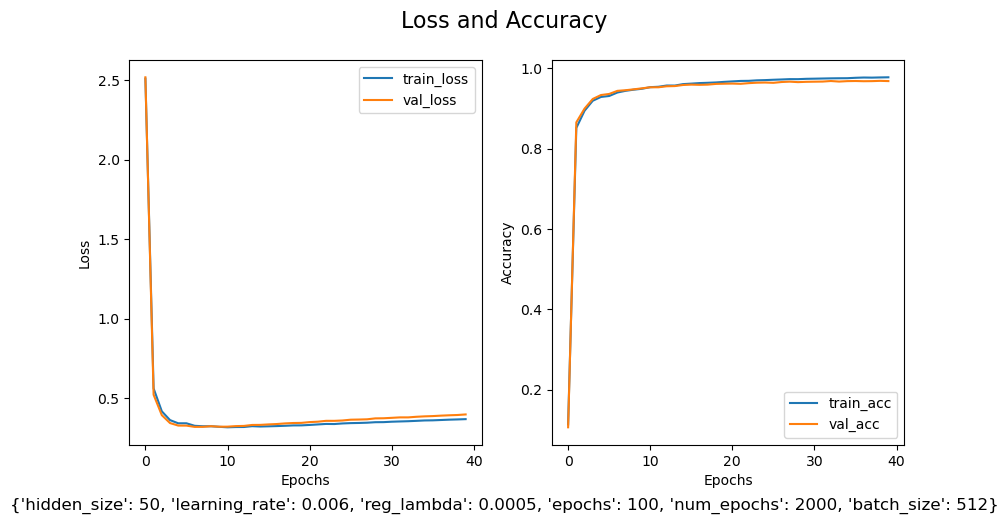

In [78]:
#训练神经网络,对参数进行微调
params = {
            'hidden_size': 50,
            'learning_rate': 0.006,
            'reg_lambda': 0.0005,
            'epochs': 100,
            'num_epochs': 2000,
            'batch_size': 512
                }
W1, b1, W2, b2, train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(x_train, y_train, x_val, y_val, 
hidden_size=params['hidden_size'], learning_rate=params['learning_rate'],reg_lambda=params['reg_lambda'], 
epochs=params['epochs'],num_epochs=params['num_epochs'],batch_size=params['batch_size'])

#存储训练结果参数
np.savez('params_best.npz', W1=W1, b1=b1, W2=W2, b2=b2)

# 导入结果参数
with np.load("params_best.npz") as f:
    W1, b1, W2, b2 = f['W1'], f['b1'], f['W2'], f['b2']

#测试神经网络
test_accuracy = test_network(x_test, y_test, W1, b1, W2, b2)
print(f'Test accuracy: {test_accuracy:.4f}')

plot_loss_acc(train_loss_list, val_loss_list, train_acc_list, val_acc_list,params)



最终参数选择
params = {
            'hidden_size': 50,
            'learning_rate': 0.006,
            'reg_lambda': 0.0005,
            'epochs': 50,
            'num_epochs': 1000,
            'batch_size': 512
                }
并且根据测试，最终选择迭代了2000次得到最终的参数结果。

可以看到，模型的loss函数先快速下降，然后趋于平衡，而后有缓慢上升的趋势，但是在loss缓慢上升时，accuracy仍在缓慢上升，说明模型存在过拟合情况，但是不严重，并且由于学到了更多的细节，所以反而使得在测试集上的准确率更高。所以我选择了让模型迭代更多的次数，而不是在loss上升时停止迭代，这样可以使得模型更加准确。

### 4、测试
导入之前利用最优超参数训练得到的模型，对测试集进行验证

In [79]:
# 导入最优模型参数
with np.load("params_best.npz") as f:
    W1, b1, W2, b2 = f['W1'], f['b1'], f['W2'], f['b2']

# 测试该模型
test_accuracy = test_network(x_test, y_test, W1, b1, W2, b2)
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.9684


可以看到在最终测试集上的准确率为0.9684,准比率和训练集上的准确率0.9770更低一些，但是并没有低很多，说明模型没有过拟合或者说只是存在比较轻微的过拟合现象。准确率比之前网格搜索粗略得到的模型要高，说明我们的超参数选择是正确的。

接下来我们对模型各层的网络参数进行可视化：

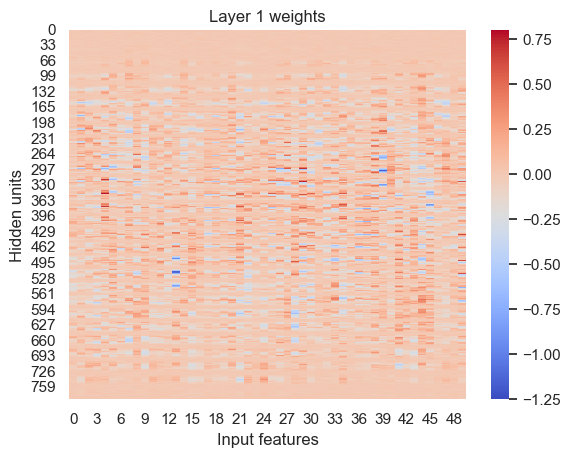

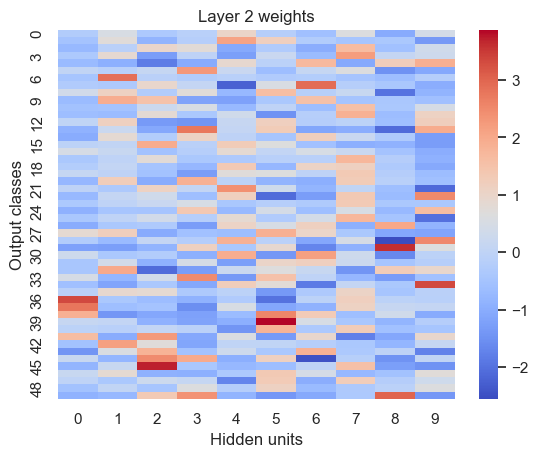

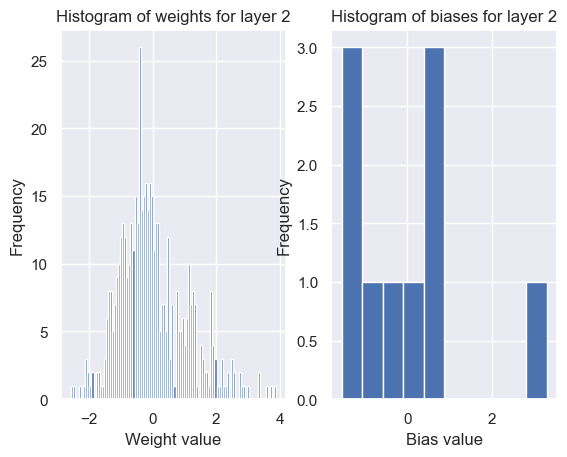

In [80]:
import seaborn as sns


# 绘制权重热力图
# 可视化第一层权重
sns.set()
sns.heatmap(W1, cmap="coolwarm")
plt.title("Layer 1 weights")
plt.xlabel("Input features")
plt.ylabel("Hidden units")
plt.show()

# 可视化第二层权重
sns.heatmap(W2, cmap="coolwarm")
plt.title("Layer 2 weights")
plt.xlabel("Hidden units")
plt.ylabel("Output classes")
plt.show()

# 可视化第一层偏差
plt.subplot(121)
plt.hist(W2.flatten(), bins=100)
plt.title("Histogram of weights for layer 2")
plt.xlabel("Weight value")
plt.ylabel("Frequency")


# 可视化第二层偏差
plt.subplot(122)
plt.hist(b2.flatten(), bins=10)
plt.title("Histogram of biases for layer 2")
plt.xlabel("Bias value")
plt.ylabel("Frequency")
plt.show()


观察可以发现：
- 第一层的参数的值比较小，而第二层的参数的值比较大，这是因为在第一层中，我们对输入的数据进行了归一化，使得输入的数据的值都在0-1之间，而在第二层中，我们没有进行归一化，所以参数的值比较大。
- 第一层的参数的值比较集中，而第二层的参数的值比较分散，这是因为在第一层中，我们使用的是sigmoid函数，而在第二层中，我们使用的是softmax函数，输出是多个数的概率分布，所以它们的值是0-1之间的，但它们的和是1，所以第二层的参数的值比较分散。
- 权重图和偏差直方图的分布可没有呈现明显的规律和模型，说明模型没有过拟合，并且也没有呈现均匀或者完全随机的分布，说明模型的参数是有意义的，学习到了一定的信息，没有欠拟合。